### Explicación del modelo

Este modelo entrenará un árbol con todas las features posibles, buscaremos una altura medianamente adecuada (entre 3 y 7 a lo sumo), pero lo hará con muestras equilibradas para el poder adquisitivo (es decir, entrenará con un data set equilibrado y testeara con un data set de la misma estructura que el original). Veamos qué sucede.

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.tree import DecisionTreeClassifier

import pandas as pd
import utils


from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from matplotlib import pyplot as plt
import seaborn as sns


In [11]:
def equilibrar(X, y):
    X_1 = X[y==1].copy()
    X_0 = X[y==0].copy()
    indexs = X_0.sample(len(X_1)).index
    X = pd.concat([X_1, X_0.loc[indexs]], ignore_index=True, sort=False)
    y = pd.concat([y[y==1],y.loc[indexs]])
    return X, y

In [12]:
df = utils.feature_engineering(utils.get_data())

In [13]:
X = df[df.columns.drop('tiene_alto_valor_adquisitivo')]
Y = df['tiene_alto_valor_adquisitivo']

X = pd.get_dummies(X)

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=112)

X_train, y_train = equilibrar(X_train, y_train)

In [15]:
model = DecisionTreeClassifier()
params = {'criterion': ['gini','entropy'],
          'splitter': ['best'],
          'min_samples_leaf': [200, 300, 400],
          'max_depth': range(6, 10)}

gscv = GridSearchCV(model, params, scoring = 'roc_auc', n_jobs=-1, cv=25, verbose=4)

gscv.fit(X_train, y_train)

Fitting 25 folds for each of 24 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 585 out of 600 | elapsed:   14.4s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed:   14.6s finished


GridSearchCV(cv=25, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(6, 10),
                         'min_samples_leaf': [200, 300, 400],
                         'splitter': ['best']},
             scoring='roc_auc', verbose=4)

In [16]:
gscv.best_score_

0.8975570969301241

In [17]:
arbol = gscv.best_estimator_
arbol.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=200)

In [18]:
print(classification_report(y_test, arbol.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86      6182
           1       0.56      0.85      0.68      1959

    accuracy                           0.80      8141
   macro avg       0.75      0.82      0.77      8141
weighted avg       0.85      0.80      0.81      8141



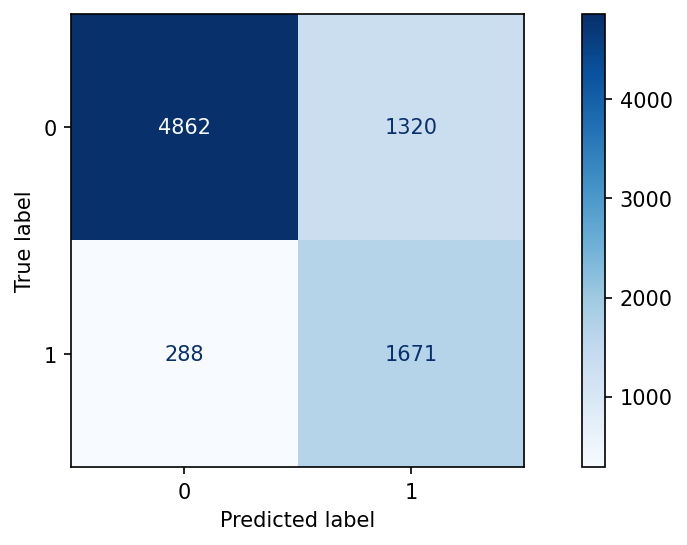

In [19]:
fig, ax = plt.subplots(figsize=(10,4), dpi=150)
plt.grid(False)
plot_confusion_matrix(arbol, X_test, y_test, cmap=plt.cm.Blues, ax=ax)
plt.show()

Ya en estas instancias podemos observar que el modelo utilizando todas las variables y equilibrando el dataset de entrenamiento no es muy bueno en general. Eso sí, a diferencia de todos los demás modelos, podemos ver que el Recall de 1s aumentó considerablemente (casi un 40%) mientras que el recall de 0s disminuyó bastante.

El accuracy final da 77%, un resultado un tanto regular.

La mejor parte de este modelo es la precisión para los 0, es decir, este modelo predice excelentemente cuando una instancia NO es 1, es decir, si yo te digo que tu instancia es CERO, lo digo con una precisión del 95%, aproximadamente. Esto será interesante para tener en cuenta en algún ensamble del tipo cascada.